# Amazon SageMaker - Multiclass classification example



This notebook uses the UCI ML Dataset, which describes using ML in Orthopedics to automate the prediction of spinal pathology conditions. This technology presents an opportunity to take steps to minimize the number of visits/prescriptions by shortening diagnosis time and instilling rejection option techniques with ML. This will leave the difficult cases to the experts, such as the Orthopedists. Disc Hernia and Spondylolisthesis, the two diagnoses in the datasets, are among the spinal pathologies that can cause musculoskeletal pain disorders. There is opportunity within computer-aided diagnostic systems that use ML techniques to identify and treat patients-at-risk objectively and effectively to minimize opioid prescriptions for pain disorders.

These datasets present both a multiclass and binary classification problem. In this notebook, we will only focus on multiclass.



---
## Creating an ML model in Amazon SageMaker for pathology prediction

In this notebook, we create a multi-class categorical classification model and  we evaluate it. The multi-class categorical classification will predict if a person has Normal, Herniated Discs, or Spondylolisthesis pathology. 

Here are the high-level steps we will follow to for this example:

   * Prepare your Amazon SageMaker Jupyter notebook.
   * Load a dataset from Amazon Simple Storage Service (S3) using Amazon SageMaker.
   * Estimate a model using the Amazon SageMaker XGBoost (eXtreme GradientBoosting) algorithm.
   * Host the model on Amazon SageMaker to make ongoing predictions.
   * Generate final predictions on the test data set.



---
## eXtreme GradientBoosting

Gradient boosting is a technique for regression und classification, which produces a prediction model in the form of an ensemble. An ensemble is a collection of predictors whose predictions are combined, usually by some sort of weighted average or vote, in order to provide an overall prediction that takes it's guidance from the collection itself. 

Boosting is an ensemble technique in which learners are learned sequentially, with early learners fitting simple models to the data and then analyzing the data for errors. Those errors identify problems or particular instances of the data that are difficult or hard to fit examples. Later models focus primarily on those examples trying to get them right. In the end, all the models are given weight and the set is combined into an overall predictor. 

Boosting is a method of converting a sequence of weak learners into a very complex predictor. It's a way of increasing complexity of a particular model. Initial learners tend to be very simple, and then the weighted combination can grow more and more complex, as learners are added.  

XGBoost is a scalable and accurate implementation of gradient boosting machines and it has proven to push the limits of computing power for boosted trees algorithms as it was built and developed for the sole purpose of model performance and computational speed. Specifically, it was engineered to exploit every bit of memory and hardware resources for tree boosting algorithms.




---
## Setup

Start by specifying:

* the Amazon SageMaker role Amazon Resource Name (ARN) used to give learning and hosting access to your data.
* the Amazon S3 bucket that will be used for training and storing model objects.

You’ll also install liac-arff because Attribute-Relation File Format (ARFF) is the formatting we’ll use, given the dataset.


In [6]:
import os
import boto3
import time
import re
from sagemaker import get_execution_role
!pip install --upgrade pip
!pip install liac-arff #(install this package to import arff)

role = get_execution_role()

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages (18.0)


Import the relevant Python libraries that we’ll use throughout the analysis.

In [7]:
import pandas as pd                               # For munging tabular data
import numpy as np                                # For matrix operations and numerical processing
import matplotlib.pyplot as plt                   # For charts and visualizations
import io                                         # For working with stream data
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import json                                       # For parsing hosting output
import sagemaker.amazon.common as smac            # For protobuf data format
import arff                                       # For installing Liac-arff module (https://pypi.python.org/pypi/liac-arff) that implements functions to read and write ARFF files in Python
import csv                                        # For converting ARFF to CSV for AWS S3 to read
from random import shuffle                        # For randomizing or shuffling data
import requests, zipfile, StringIO                # For unzipping and extracting files from zipped files
import sklearn as sk                              # For access to a variety of machine learning models
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from sklearn.datasets import dump_svmlight_file   # For outputting data to libsvm format for xgboost
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function

Define the Amazon S3 bucket used for the example.

In [8]:
bucket = 'sagemaker-uyar' #  enter your s3 bucket where you will copy data and model artificats
prefix = 'xgboost-multiclass'  # place to upload training files within the bucket

---
## Data

Data comes in two separate files: column_2c_weka.arff and column_3c_weka.arff. The column names are in both files.

The hosted zip file (“vertebral_column_data”) consists of four data files, two of which contain the actual data and attributes: column_2C_weka.arff for binary classification and column_3C_weka.arff for categorical classification. The dataset consists of 310 rows representing 310 patient records.



---

### Classes and Attributes
The dataset includes six biomechanical attributes of the patient and the outcome or pathology. The attributes describe the vertebral column (group of vertebras, invertebrate discs, nerves, muscles, medulla and joints). These spino-pelvic system parameters include angle of pelvic incidence (PI), angle of pelvic tilt (PT), lordosis angle, sacral slope (SS), pelvic radius, and grade of slipping.

Each patient has six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius, and grade of spondylolisthesis. There is also a class or diagnosis for each patient in multiclass: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO).

![Spino-Pelvic-System](img/spino-pelvic-system.png)



## Prepare: 

To get the data into Amazon S3 in a format that XGBoost can read, I extracted the relevant files from the zipped file, converted to CSV, and added them to the Amazon S3 bucket so that S3 and Amazon SageMaker can read them.


#### Extract Files and Read Data Pre-Conversion

In [9]:
import requests, zipfile, StringIO
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'

r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(StringIO.StringIO(r.content))
Vertebral_zip.extractall()

####  Read Data Pre-Conversion

In [10]:
# Reading Arff --> Data --> Binary/Categorical Conversion --> CSV
data_dict = arff.load(open('column_3C_weka.arff', 'rb')) #Read arff for multiclass
data_arff = data_dict["data"]                            #List of Datapoints only

# Display Arff file attributes pre-conversion
for i in data_dict: 
    print i

attributes
relation
description
data


#### Conversion
Now we take the extracted file and convert it into .csv files in the proper format (Ortho_dataset_2.csv). In the multi-class categorical classification file, I replaced “Normal”, “Hernia”, and “Spondylolisthesis” with “0,” “1,” “2,” respectively.

See the following Python script to read the .arff file and convert it to .csv format.

In [12]:
# # Reading Arff --> Data --> Categorical Conversion --> CSV
# data_dict = arff.load(open('column_3C_weka.arff', 'rb')) #Read arff for multiclass
# data_arff = data_dict["data"]                            #List of Datapoints only

# ## Display Arff file pre-conversion
# # display(data_arff) 

shuffle(data_arff) #Shuffle the patients within the dataset 
attributes_tup = data_dict["attributes"] #Extract attribute tuples
Attributes = []
for i in attributes_tup: #Extract only relevant attribute names
    for tup in i[::2]: 
        Attributes.append(tup)

Ortho_dataset_2 = [Attributes] + data_arff


## Changing to categorical  values : "Hernia" to 1 and "Normal" to 0, "Spondylolisthesis" to 2
for row in Ortho_dataset_2: 
    for i in row: 
        if i == "Hernia":
            row.remove(i)
            row.append("1")
        if i == "Normal": 
            row.remove(i)
            row.append("0")
        if i == "Spondylolisthesis": 
            row.remove(i)
            row.append("2")              
            
# Writing dataset to CSV 
def writeCsvFile(filename, dataset): 
    """
    @filename: string, filname to save it as
    @dataset: list of list of items

    Write data to file
    """
    mycsv = csv.writer(open(filename, 'wb'))
    for row in dataset:
        mycsv.writerow(row)
        
##Name and dataset:
writeCsvFile('Ortho_dataset_2.csv', Ortho_dataset_2)

# read the data
data = pd.read_csv('Ortho_dataset_2.csv', header=0) #Header is zero to indicate first row is column headers

# save the data
data.to_csv("Mdata.csv", sep=',', index=False)

# read test data
data_test = pd.read_csv('Ortho_dataset_2.csv', header=0, skiprows=0) #Header is zero to indicate first row's column headers

# set column names
data.columns = ["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius",
                     "degree_spondylolisthesis","diagnosis"] 


data_test.columns = ["pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius",
                     "degree_spondylolisthesis","diagnosis"] 

##Create data bins to move diagnosis column to the first column
diagnosis_col = data.iloc[:,6]  #Diagnosis columns

# Creating new dataframe with diagnosis as first column
mdata_test_bin = pd.concat([diagnosis_col, data_test.iloc[:, 0:6]], axis=1) 
mdata_bin = pd.concat([diagnosis_col, data.iloc[:, 0:6]], axis = 1)

# Set column names for dataframes
mdata_bin.columns = ["diagnosis","pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius",
                     "degree_spondylolisthesis"] 

mdata_test_bin.columns = ["diagnosis","pelvic_incidence","pelvic_tilt","lumbar_lordosis_angle","sacral_slope","pelvic_radius",
                     "degree_spondylolisthesis"] 



## Exploration

Now we’ll explore the dataset to understand the size of data, the various fields, the values that different features take, and the distribution of target values.                                          

### Data exploration and transformations

For an effective ML model and potentially for higher accuracy, the more data the better. Since the dataset we’re using is quite limited, I didn’t remove any features. This methodology can be applied for larger data sets.

In [13]:
# set display options
pd.set_option('display.max_columns', 100)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 6)          # Keep the output on one page

# # display data post conversion from arff to csv
# display(data)
# # display(data_test)

# # display positive and negative counts
# display(data.iloc[:,6].value_counts())
display(data_test.iloc[:,6].value_counts())


#display the data sets post column changes 
# display(mdata_bin)
# display(mdata_test_bin)

# count number of positives and negatives
display(mdata_bin.iloc[:,0].value_counts())
print("data_test:")
display(mdata_test_bin.iloc[:,0].value_counts())

2    150
0    100
1     60
Name: diagnosis, dtype: int64

2    150
0    100
1     60
Name: diagnosis, dtype: int64

data_test:


2    150
0    100
1     60
Name: diagnosis, dtype: int64

### Data Histograms and Correlation

Here we can visualize the data to see the spread of data within each feature in a histogram and scatter matrix. The scatter-plot matrix displays the correlation between pairs of variables. The matrix makes it easy to look at all pairwise correlations in one place.

,diagnosis,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,1.161290,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,0.884852,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
...,...,...,...,...,...,...,...
50%,1.000000,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,2.000000,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,2.000000,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


,diagnosis,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
diagnosis,1.000000,0.537638,0.348231,0.525466,0.430734,-0.304099,0.608705
pelvic_incidence,0.537638,1.000000,0.629199,0.717282,0.814960,-0.247467,0.638743
pelvic_tilt,0.348231,0.629199,1.000000,0.432764,0.062345,0.032668,0.397862
...,...,...,...,...,...,...,...
sacral_slope,0.430734,0.814960,0.062345,0.598387,1.000000,-0.342128,0.523557
pelvic_radius,-0.304099,-0.247467,0.032668,-0.080344,-0.342128,1.000000,-0.026065
degree_spondylolisthesis,0.608705,0.638743,0.397862,0.533667,0.523557,-0.026065,1.000000


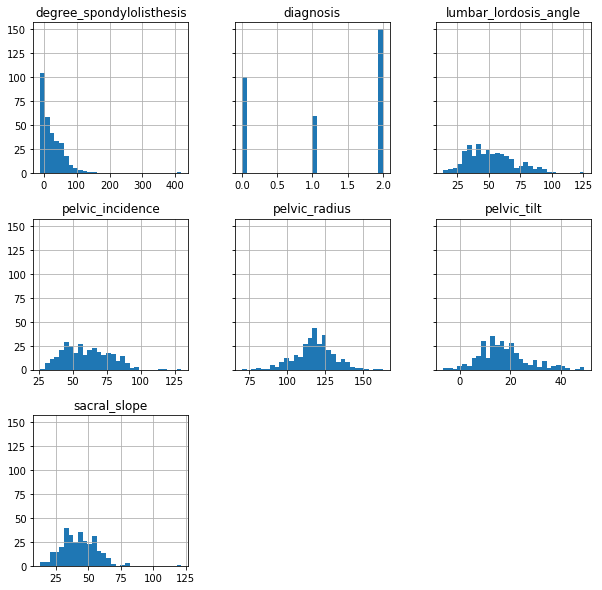

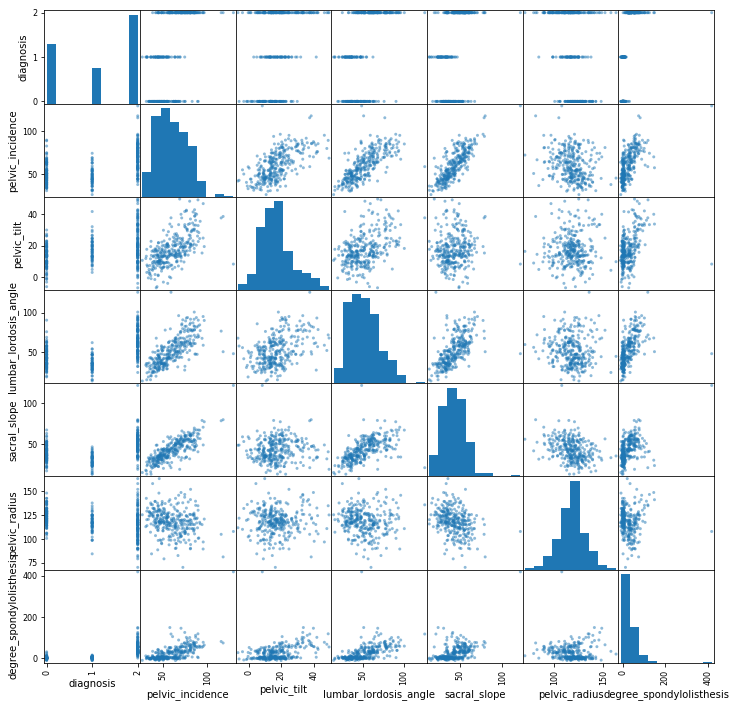

In [14]:
# Histograms for each numeric features
display(mdata_bin.describe())
%matplotlib inline
hist = mdata_bin.hist(bins=30, sharey=True, figsize=(10, 10))

##correlation
display(mdata_bin.corr())
pd.plotting.scatter_matrix(mdata_bin,figsize=(12, 12))
plt.show()

### Data Description
Let's talk about the data.  At a high level, we can see:

* There are 7 columns and around 217 rows in the training data
* There are 7 columns and around 93 rows in the test data
* Diagnosis is the target field

_**Specifics on the features:**_ 
* 6 out of 6 features are numeric

**Target variable:**
* `diagnosis: 
    MultiClass: Whether the patient has Hernia, Spondylosisthesis or is Normal
    
    
---

## Training

For our first training algorithm we use the xgboost algorithm. xgboost is an extremely popular, open-source package for gradient boosted trees. It’s computationally powerful, fully featured, and has been successfully used in many machine learning competitions. Let’s start with a simple xgboost model, trained using the Amazon SageMaker managed, distributed training framework.

First we’ll need to specify training parameters. These include the following:

   * The role to use
   * Our training job name
   * The xgboost algorithm container
   * Training instance type and count
   * S3 location for training data
   * S3 location for output data
   * Algorithm hyperparameters

The supported training input format is csv, libsvm. For csv input, we assume that the input is separated by delimiters (automatically detect the separator using Python’s built-in sniffer tool), without a header line, and the label is in the first column. The Scoring Output Format is csv. Our data is in CSV format, so we’ll convert our dataset to the way that the Amazon SageMaker XGBoost supports. We will keep the target field in first column and remaining features in the following columns. We will remove the header line. We will also split the data into a separate training and validation sets. Finally, we’ll store the data in our S3 bucket.



Split the data into 70% training and 15% validation and save it before calling XGboost

In [15]:
# Split the data randomly as 70% for training and remaining 30% and save them locally
mtrain_list = np.random.rand(len(mdata_bin)) < 0.7
mdata_train = mdata_bin[mtrain_list]
mdata_val = mdata_bin[~mtrain_list]
mdata_train.to_csv("mformatted_train.csv", sep=',', header=False, index=False) # save training data 
mdata_val.to_csv("mformatted_val.csv", sep=',', header=False, index=False) # save validation data
mdata_test_bin.to_csv("mformatted_test.csv", sep=',', header=False,  index=False) # save test data

print mdata_train.shape
print mdata_val.shape

(221, 7)
(89, 7)


#### Upload training and validation data sets in the s3 bucket and prefix provided

In [16]:
mtrain_file = 'mformatted_train.csv'
mval_file = 'mformatted_val.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/', mtrain_file)).upload_file(mtrain_file)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'val/', mval_file)).upload_file(mval_file)


#### Specify parameters based on the model
* Multiclass: 
    objective: "multi:softmax", 
    num_class: "3"

In [17]:
Mxgboost_containers = {'us-west-2' : '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
                    'us-east-1' : '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
                    'us-east-2' : '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
                    'eu-west-1' : '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest',
                    'eu-central-1' : '813361260812.dkr.ecr.eu-central-1.amazonaws.com/xgboost:latest'}

In [19]:
import boto3
from time import gmtime, strftime

mjob_name = 'Mxgboost-ortho-presentation-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", mjob_name)

mcreate_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": Mxgboost_containers[boto3.Session().region_name],
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/output-xgboost/".format(bucket, prefix),
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 1000
    },
    "TrainingJobName": mjob_name,
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.1",
        "gamma":"1",
        "min_child_weight":"1",
        "silent":"0",
        "objective": "multi:softmax", #for multiclass
        "num_round": "20",
        "num_class": "3", #remove if not multiclass
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri":  "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/val/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        }
    ]
}



('Training job', 'Mxgboost-ortho-presentation-2018-09-20-15-33-39')


In [20]:
%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**mcreate_training_params)

status = sm.describe_training_job(TrainingJobName=mjob_name)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=mjob_name)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=mjob_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')  
    
# Estimated Time: ~6 minutes  

InProgress
CPU times: user 84 ms, sys: 16 ms, total: 100 ms
Wall time: 4min


---

## Hosting

Now that we've trained the `xgboost` algorithm on our data, let's setup a model which can later be hosted.  We will:
1. Point to the scoring container
1. Point to the model.tar.gz that came from training
1. Create the hosting model

In [24]:
model_name=mjob_name + '-mdl'
Mxgboost_hosting_container = {
    'Image': Mxgboost_containers[boto3.Session().region_name],
    'ModelDataUrl': sm.describe_training_job(TrainingJobName=mjob_name)['ModelArtifacts']['S3ModelArtifacts'],
    'Environment': {'this': 'is'}
}

create_model_response = sm.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=Mxgboost_hosting_container)

In [23]:
print(create_model_response['ModelArn'])
print(sm.describe_training_job(TrainingJobName=mjob_name)['ModelArtifacts']['S3ModelArtifacts'])

arn:aws:sagemaker:eu-central-1:272741811106:model/mxgboost-ortho-presentation-2018-09-20-15-33-39-mdl
s3://sagemaker-uyar/xgboost-multiclass/output-xgboost/Mxgboost-ortho-presentation-2018-09-20-15-33-39/output/model.tar.gz


After we set up a model, we can configure what our hosting endpoints should be. Here we specify the following:

  1. EC2 instance type to use for hosting.
  2. Initial number of instances.
  3. Our hosting model name.


In [25]:
from time import gmtime, strftime

mendpoint_config_name = 'MXGBoostEndpointConfig-presentation-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(mendpoint_config_name)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = mendpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'InitialVariantWeight':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

MXGBoostEndpointConfig-presentation-2018-09-20-15-47-27
Endpoint Config Arn: arn:aws:sagemaker:eu-central-1:272741811106:endpoint-config/mxgboostendpointconfig-presentation-2018-09-20-15-47-27


### Create endpoint
Lastly, we create the endpoint that serves up the model, through specifying the name and configuration defined earlier. The end result is an endpoint that can be validated and incorporated into production applications. This takes about 7-11 minutes to complete.

In [26]:
%%time
import time

mendpoint_name = 'MXGBoostEndpoint-presentation' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(mendpoint_name)
create_endpoint_response = sm.create_endpoint(
    EndpointName=mendpoint_name,
    EndpointConfigName=mendpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=mendpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=mendpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

# Estimated Time: ~10 minutes

MXGBoostEndpoint-presentation2018-09-20-15-48-13
arn:aws:sagemaker:eu-central-1:272741811106:endpoint/mxgboostendpoint-presentation2018-09-20-15-48-13
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:eu-central-1:272741811106:endpoint/mxgboostendpoint-presentation2018-09-20-15-48-13
Status: InService
CPU times: user 88 ms, sys: 16 ms, total: 104 ms
Wall time: 6min


### Prediction
 Here is the model that was created, used to predict values

In [27]:
runtime= boto3.client('runtime.sagemaker')

In [28]:
# Function to create a csv from our numpy array

def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

In [29]:
# Function to generate prediction through sample data
def do_predict(data, endpoint_name, content_type):
    
    payload = np2csv(data)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    return preds

# Function to iterate through a larger data set and generate batch predictions
def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            datav = data.iloc[offset:(offset+batch_size),:].as_matrix()
            results = do_predict(datav, endpoint_name, content_type)
            arrs.extend(results)
        else:
            datav = data.iloc[offset:items,:].as_matrix()
            arrs.extend(do_predict(datav, endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [30]:
### read the saved data for scoring
mdata_train = pd.read_csv("mformatted_train.csv", sep=',', header=None) 
mdata_test = pd.read_csv("mformatted_test.csv", sep=',', header=None) 
mdata_val = pd.read_csv("mformatted_val.csv", sep=',', header=None) 
# display(mdata_val.iloc[:,0].value_counts())

### Generate predictions on train, validation and test sets

In [31]:
mpreds_train_xgb = batch_predict(mdata_train.iloc[:, 1:], 1000, mendpoint_name, 'text/csv')
mpreds_val_xgb = batch_predict(mdata_val.iloc[:, 1:], 1000, mendpoint_name, 'text/csv')
mpreds_test_xgb = batch_predict(mdata_test.iloc[:,1:],1000, mendpoint_name, 'text/csv')

...

---
## Evaluate Model Accuracy for Multiclass Categorical

There are many ways to compare the performance of a machine learning model.

For multiclass models, typically we use the F1 measure and not the AUC score, area under the ROC curve which is typically used in binary models. The F1 measure is a statistical measure of the precision and recall of all the classes in the model. The score ranges from 0 to 1; the higher the score, the better the accuracy of the model. For example, an F1 score of ~0.9 would indicate a better model than a score of 0.7.

Other evaluation metrics include Sensitivity, or true positive rate, and Precision, or positive predictive value. 

In [32]:
from sklearn import metrics
mtrain_labels = mdata_train.iloc[:,0];
mval_labels = mdata_val.iloc[:,0];
mtest_labels = mdata_test.iloc[:,0];

Training_f1 = metrics.f1_score(mtrain_labels, mpreds_train_xgb, average=None)
Validation_f1= metrics.f1_score(mval_labels, mpreds_val_xgb, average=None)
# fbeta_test= metrics.f1_score(mtest_labels, mpreds_test_xgb, average=None)
prec, rec, fbeta_test, support = metrics.precision_recall_fscore_support(mtest_labels, mpreds_test_xgb, average = None)
metrics.precision_recall_fscore_support(mtest_labels, mpreds_test_xgb, average = None)

print"Average Training F1 Score", (Training_f1[0]+Training_f1[1]+Training_f1[2])/3 ##0.95594
print"Average Validation F1 Score", (Validation_f1[0]+Validation_f1[1]+Validation_f1[2])/3 ##0.7922

print "Test Evaluation: "
print "Average F1 Score: ", (fbeta_test[0]+fbeta_test[1]+fbeta_test[2])/3 ##0.91
print "Normal F1 Score: ", fbeta_test[0] ## 0.8944
print "Hernia F1 Score: ", fbeta_test[1] ## 0.8524
print "Spondylosisthesis F1 Score: ", fbeta_test[2] ## 0.9832
print "Average Precision Score: ", (prec[0]+prec[1]+prec[2])/3 ##0.91
print "Average Sensitivity/TPR Score: ", (rec[0]+rec[1]+rec[2])/3 ##0.91

Average Training F1 Score 0.95259763068
Average Validation F1 Score 0.819706498952
Test Evaluation: 
Average F1 Score:  0.916897803988
Normal F1 Score:  0.904522613065
Hernia F1 Score:  0.859504132231
Spondylosisthesis F1 Score:  0.986666666667
Average Precision Score:  0.916072197384
Average Sensitivity/TPR Score:  0.917777777778


This ML model received an average F1 score of 0.94. 



## Confusion Matrix

You can also delve into the performance for each class by looking at the confusion matrix.

The confusion matrix provides a visual representation of the performance based on the accuracy of the multiclass classification predictive model. In this table you can find the percentage of true positives and false positives.

In [33]:
import itertools
         
class_names = ["Normal","Hernia", "Spondylosisthesis"]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


For example, you see class (or diagnosis) Spondylosisthesis had a high accuracy rate (99%) with 149 cases out of 150 cases predicted correctly in the evaluation dataset. The F1 score of 0.98 is also relatively high. However, class Hernia had a lower F1 score of 0.85 showing that the model confused it with the Normal pathology. For more information on multiclass model evaluation and insights, go to Multiclass Model Insights: https://docs.aws.amazon.com/machine-learning/latest/dg/multiclass-model-insights.html.

Confusion matrix, without normalization
[[ 90   8   2]
 [  8  52   0]
 [  1   1 148]]
Normalized confusion matrix
[[ 0.9   0.08  0.02]
 [ 0.13  0.87  0.  ]
 [ 0.01  0.01  0.99]]


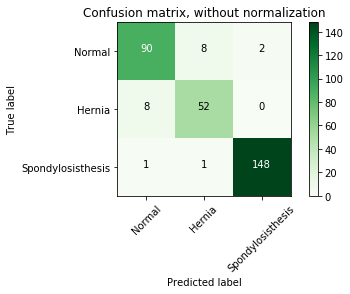

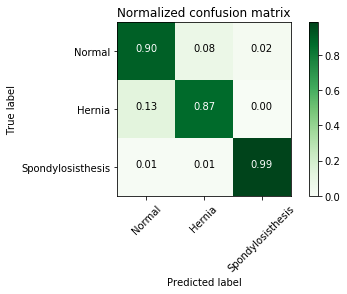

In [34]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(mtest_labels, mpreds_test_xgb)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
#Confusion matrix, without normalization
# [[ 89   9   2]
#  [  8  52   0]
#  [  2   1 147]]
# Normalized confusion matrix
# [[ 0.89  0.09  0.02]
#  [ 0.13  0.87  0.  ]
#  [ 0.01  0.01  0.98]]

##### Run the command below to delete endpoints once you are done.

In [35]:
sm.delete_endpoint(EndpointName=mendpoint_name)

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 20 Sep 2018 16:03:21 GMT',
   'x-amzn-requestid': '45aa519d-0200-4db4-ae36-17d9d8af9023'},
  'HTTPStatusCode': 200,
  'RequestId': '45aa519d-0200-4db4-ae36-17d9d8af9023',
  'RetryAttempts': 0}}